In [1]:
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from phasespace import Particle
from phasespace.kinematics import lorentz_vector, lorentz_boost
import tensorflow as tf
import tensorflow_probability as tfp
import zfit

from utils.kin_utils import *

ztf = zfit.ztf
ztyping = zfit.util.ztyping
ztypes = zfit.settings.ztypes


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



/Users/davide/miniconda3/envs/zfit_env/lib/python3.6/site-packages/zfit/util/execution.py:57: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.run.set_n_cpu(your_cpu_number)`
  warnings.warn("Not running on Linux. Determining available cpus for thread can fail"


In [2]:
zfit.run.check_numerics = False

In [3]:
zfit.run.check_numerics

False

In [4]:
mmu_mass = 105.0
mB_mass = 5280.0
mKst_mass = 892.0

minq=2*mmu_mass
maxq=(mB_mass-mKst_mass)

el1 = Particle('l1', mmu_mass)
el2 = Particle('l2', mmu_mass)

def modq(min_mass, max_mass, n_events):
    
        min_mass = tf.cast(min_mass, tf.float64)
        max_mass = tf.cast(max_mass, tf.float64)

        min_mass = tf.broadcast_to(min_mass, shape=(n_events,))
        
        modq_mass = tfp.distributions.Uniform(low=min_mass, high=max_mass).sample()
        
        return modq_mass
    
q=Particle('q', modq).set_children(el1, el2)
Kst = Particle('Kst', mKst_mass)

B = Particle('B', mB_mass).set_children(Kst, q)

#weights, particles = B.generate(n_events=10000)
weights_np, particles_np = B.generate(n_events=1000000)
weights, particles = B.generate_tensor(n_events=1000000)

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
Kst=particles_np['Kst']
l1 =particles_np['l1']
l2 =particles_np['l2']
q_np=particles_np['q']
q2_array=scalar_product_4_np(q_np,q_np)
q2_range=np.arange(q2_array.min(), q2_array.max(),1000)
print(np.sqrt(q2_array.min()/4), np.sqrt(q2_array.max())+mKst_mass)

105.00049473122846 5279.995436140764


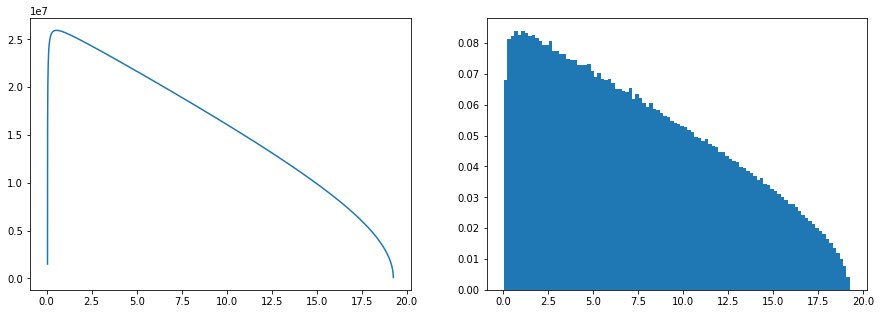

In [7]:
val=np.sqrt(lambda_function_np(mB_mass, mKst_mass, q2_range))*np.sqrt(beta_l_np(q2_range, mmu_mass))
plt.subplot(1,2,1)
plt.plot(q2_range/1e6, val);
fig=plt.gcf()
plt.subplot(1,2,2)
plt.hist(q2_array/1e6, weights=weights_np, bins=100,density=True);
fig=plt.gcf()
fig.set_size_inches(15,5);

In [8]:
class GaussianSampleAndWeights():

        def __call__(self, n_to_produce, limits, dtype):
            
            n_to_produce = tf.cast(n_to_produce, dtype=tf.int32)

            weights, phase_space_sample = B.generate_tensor(n_events=n_to_produce) #check order 
            
            weights_out = 1/weights
            phase_space_sample_tensor = tf.concat([phase_space_sample["Kst"],phase_space_sample["q"],phase_space_sample["l1"],phase_space_sample["l2"],], axis=1)
            
            weights_max = None
            
            thresholds = tf.random_uniform(shape=(n_to_produce,), dtype=dtype)
            
            return phase_space_sample_tensor, thresholds, weights_out, weights_max, n_to_produce
        

In [9]:
class dGamma(zfit.pdf.ZPDF):
    
    _PARAMS = ['mB','mKst','ml']
    _N_OBS = 16

    def _unnormalized_pdf(self, x):
        
        ml = self.params['ml']
        mB = self.params['mB']
        mKst = self.params['mKst']
        
        list_ps= x.unstack_x()
        new_list_ps = [tf.expand_dims(ele, axis=1) for ele in list_ps] 
        pKstx, pKsty, pKstz, pKstE, qx, qy, qz, qE, p1x, p1y, p1z, p1E, p2x, p2y, p2z, p2E = new_list_ps
        
        pKst = lorentz_vector(tf.concat([pKstx, pKsty, pKstz],axis=-1), pKstE)
        p1 = lorentz_vector(tf.concat([p1x, p1y, p1z],axis=-1), p1E)
        p2 = lorentz_vector(tf.concat([p2x, p2y, p2z],axis=-1), p2E)
        qvec_B = tf.concat([qx, qy, qz],axis=-1)
        q = lorentz_vector(qvec_B, qE)

        z = tf.cast(tf.expand_dims(tf.stack([0., 0., 1., 0.],         axis=0), axis=0),dtype=tf.float64)
        
        #assert q==p1+p2
        q2=scalar_product_4(q,q)
        modq = ztf.sqrt(q2)
        
        q_in_q_rf = lorentz_vector(tf.zeros_like(qvec_B), modq)
        p1q = lorentz_boost(p1, qvec_B/qE)
        
        costheta_l= tf.expand_dims(get_costheta_l(p1q, z), axis=1)
        
        #pdf=costheta_l*beta_l(q2, ml)
        
        #pdf = 1./(1.-beta_l(q2, ml)*costheta_l)        
        #pdf = (1/(q2))*(1+ztf.square(costheta_l))*(1/(q2+21e6))#*ztf.exp(-ztf.square(q2-9e6))
        #pdf = ztf.sqrt(lambda_function(mB, mKst, q2))*beta_l(q2,ml)
        #pdf = tf.ones_like(q2) 
        #pdf = q2/(1.-beta_l(q2, ml)*costheta_l)
        pdf = 1/(1.-costheta_l*beta_l(q2,mmu_mass))
        
        return pdf[:, 0]


In [10]:
lepton_min_E = 105
lepton_max_E = 2700

lepton_min_p = -2700
lepton_max_p = 2700

Kst_min_E = 892.
Kst_max_E = 2700

Kst_min_p = -2700
Kst_max_p = 2700

q_min_E = 2700
q_max_E = 4400

q_min_p = -2700
q_max_p = 2700

In [11]:
lower =((Kst_min_p,  Kst_min_p,  Kst_min_p,  mKst_mass, q_min_p, q_min_p, q_min_p, q_min_E, lepton_min_p,  lepton_min_p,  lepton_min_p,  lepton_min_E, lepton_min_p,  lepton_min_p,  lepton_min_p,  lepton_min_E,),)
upper =((Kst_max_p , Kst_max_p , Kst_max_p , Kst_max_E, q_max_p, q_max_p, q_max_p, q_max_E, lepton_max_p,  lepton_max_p , lepton_max_p , lepton_max_E, lepton_max_p , lepton_max_p , lepton_max_p , lepton_max_E,),)

#lower = ((lower_Kstx, lower_Ksty,  lower_Kstz, lower_KstE, lower_l1x, lower_l1y,  lower_l1z, lower_l1E, lower_l2x, lower_l2y,  lower_l2z, lower_l2E,  ),)
#upper = ((upper_Kstx, upper_Ksty,  upper_Kstz, upper_KstE, upper_l1x, upper_l1y,  upper_l1z, upper_l1E, upper_l2x, upper_l2y,  upper_l2z, upper_l2E,  ),)

obs = zfit.Space(["pKstx","pKsty","pKstz","pKstE", 
                  "qx", "qy", "qz", "qE",
                  "p1x"  ,"p1y"  ,"p1z"  ,"p1E"  , 
                  "p2x"  ,"p2y"  ,"p2z"  ,"p2E" ],
                 limits=(lower,upper))



In [12]:
mlepton_par = zfit.Parameter('ml', mmu_mass)
mB_par = zfit.Parameter('mB', mB_mass)
mKst_par = zfit.Parameter('mKst', mKst_mass)

In [13]:
pdf = dGamma(obs=obs, ml = mlepton_par, mB = mB_par, mKst = mKst_par)
#pdf = dGamma(obs=obs, ml = m_lepton)
pdf._sample_and_weights=GaussianSampleAndWeights

In [14]:
sampler = pdf.create_sampler(n=100000)

Instructions for updating:
Use tf.cast instead.


In [15]:
zfit.settings.set_verbosity(10)

In [16]:
for i in range(1):
    sampler.resample()


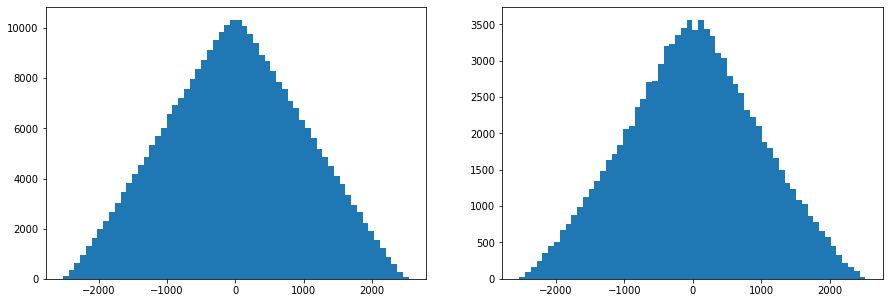

In [17]:
a=sampler.to_pandas()  
plt.subplot(1,2,1)
plt.hist(l1[:,0],weights=weights_np,bins=60);
plt.subplot(1,2,2)
plt.hist(a['p1x'].values[:],bins=60);
fig=plt.gcf()
fig.set_size_inches(15,5)

In [18]:
p1x=a['p1x'].values[:]
p1y=a['p1y'].values[:]
p1z=a['p1z'].values[:]
p1E=a['p1E'].values[:]

p2x=a['p2x'].values[:]
p2y=a['p2y'].values[:]
p2z=a['p2z'].values[:]
p2E=a['p2E'].values[:]

qx =a['qx'].values[:]
qy =a['qy'].values[:]
qz =a['qz'].values[:]
qE =a['qE'].values[:]

p1=np.array([p1x,p1y,p1z,p1E]).transpose()
p2=np.array([p2x,p2y,p2z,p2E]).transpose()
q = np.array([qx,qy,qz,qE]).transpose()
#q = p1 + p2

In [19]:
q2_from_sample=scalar_product_4_np(q,q)

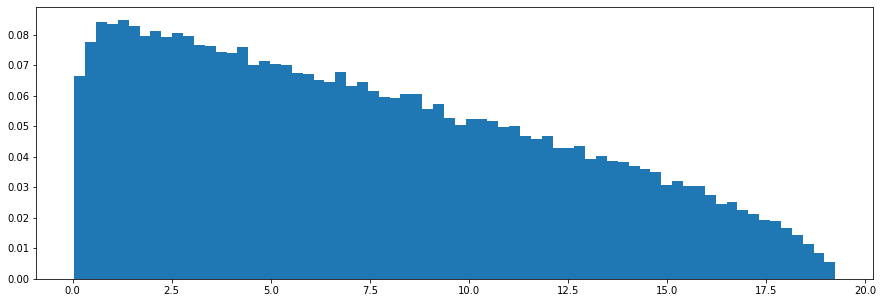

In [20]:
plt.hist(q2_from_sample/1e6,bins=70, density=True);
fig=plt.gcf()
fig.set_size_inches(15,5);